# CSC413 Assignment 1: Word Embeddings

**Deadline**: February 4, 2020 by 10pm

**Submission**: Compile and submit a PDF report containing your code, outputs,
and your written solutions. Do not use screenshots and images to present
textual code/output (other than legible, hand-written answer).
You may export the completed notebook on Google Colab, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

You must work individually on this assignment.

Based on an assignment by George Dahl, Jing Yao Li, and Roger Grosse

In this assignment, we will build a neural network that can predict the next word
in a sentence given the previous three. We will apply an idea called *weight sharing*
to go beyond the multi-layer perceptrons that we discussed in class.

We will also solve this problem problem twice: once in numpy, and once
using PyTorch. When using numpy, you'll implement the backpropagation
computation manually.

The prediction task is not very interesting on its own, but in learning to predict
subsequent words given the previous three, our neural networks will learn
about how to *represent* words. In the last part of the assignment, we'll explore
the *vector representations* of words that our model produces, and analyze these
representations.

The assignment is structured as follows:

- Question 1. Data exploration
- Question 2. Background Math
- Question 3. Building the Neural Network in NumPy
- Question 4. Building the Neural Network in PyTorch
- Question 5. Analyzing the embeddings

You may modify the starter code, including changing the signatures of helper 
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [1]:
import pandas
import pdb
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like.
Download the file `raw_sentences.txt` from Quercus.

If you're using Google Colab, upload the file to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Find the path to `raw_sentences.txt`:

In [3]:
file_path = '/content/gdrive/My Drive/CSC413/A1/raw_sentences.txt' 

You might find it helpful to know that you can run shell commands (like `ls`) by
using `!` in Google Colab, like this:

In [ ]:
!ls /content/gdrive/My\ Drive/
!mkdir /content/gdrive/My\ Drive/CSC413

'Ace The Interview with NexJ Systems.pdf'
 adit_krishnan.jpg
'adit_resume (1).pdf'
'adit_resume (2).pdf'
'adit_resume (3).pdf'
'adit_resume (4).pdf'
'adit_resume (5).pdf'
'adit_resume (6).pdf'
 adit_resume.pdf
'Anthro Textbook'
'Aurélien Géron - Hands-On Machine Learning with Scikit-Learn and TensorFlow Concepts, Tools, and Techniques to Build Intelligent Systems-O’Reilly Media (2017).pdf'
'Bayer Internship Feedback.gform'
'Book a Road Test_ Confirmation.pdf'
'Brian S. Everitt, Torsten Hothorn - A handbook of statistical analyses using R-Chapman & Hall_CRC (2006).pdf'
'Calculus One and Several Variables (10th edition).pdf'
 CalculusVolume3-OP_n7Nj74c.pdf
'Colab Notebooks'
'Copy of Geotab | Drop-in Meetings.gdoc'
'Copy of Intel Corporation - Programmable Solutions Group | Drop-in Meetings.gdoc'
'Copy of Qualcomm - Automotive Software.gdoc'
'Copy of Tutorial - Python,Docker,DigitalOcean,MongoDB,Cloudflare.gslides'
'Course Notes.pdf'
 covid19vaccine
 Crowdmark_mat232_midterm_1.pdf
 Crow

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [4]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [5]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use 10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [6]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 2 pts

To get an understanding of the data set that we are working with,
start by printing 10 sentences in the training set.

Explain how punctuations are treated in our word representation, and how words
with apostrophes are represented.

(Note that for questions like this, you'll need to supply both your code **and**
the output of your code to earn full credit.)

In [ ]:
print(train[10:20])

[['but', 'for', 'me', ',', 'now', ',', 'this', 'is', 'it', '.'], ['she', "'s", 'still', 'there', 'for', 'us', '.'], ['it', "'s", 'part', 'of', 'this', 'game', ',', 'man', '.'], ['it', 'was', ':', 'how', 'do', 'we', 'get', 'there', '?'], ['but', 'they', 'do', 'nt', 'last', 'too', 'long', '.'], ['more', 'are', 'like', 'me', ',', 'she', 'said', '.'], ['who', 'do', 'you', 'think', 'they', 'want', 'to', 'be', 'like', '?'], ['no', ',', 'he', 'could', 'not', '.'], ['so', 'i', 'left', 'it', 'up', 'to', 'them', '.'], ['we', 'were', 'nt', 'right', '.']]


Punctuations are treated as seperate words and words with apostrophes are also treated as seperate words (ex. she's is represented as "she", "'s") 

### Part (b) -- 4 pts

Before building models, it is important to understand the data that we
work with, and the *distributional properties* of the data. In other words,
answer the following questions:

- How long is the average sentence in the training set?
- How many unique words are there in the training set?
- What are the 10 most common words in the training set?
- How many total words are there in the training set? 
- How often does each of these words appear in the training sentences? Express this quantity as a percentage of total number of words in the training set.

You might find Python's `collections.Counter` class helpful.

In [ ]:
from collections import Counter
# Average sentence length
sentence_length = sum([sum([len(s)]) for s in train])
print("Average Sentence Length: ", sentence_length/len(train))
# Unique Words 
vocab = set(w for s in train for w in s)
print("Unique Words: ", len(vocab))
# 10 most common words 
print("10 most common words: ", Counter([w for s in train for w in s]).most_common(10))
# Total words in training set
print("Total words: ", sum(Counter([w for s in train for w in s]).values()))
# How often each word appears in the training sentences
# Store total word count in variable
total_words = sum(Counter([w for s in train for w in s]).values())
dct = {w: (count / total_words)*100 for w, count in Counter([w for s in train for w in s]).items()}
print("Word occurence (as percentage): ", dct)


Average Sentence Length:  7.790713045281356
Unique Words:  250
10 most common words:  [('.', 64297), ('it', 23118), (',', 19537), ('i', 17684), ('do', 16181), ('to', 15490), ('nt', 13009), ('?', 12881), ('the', 12583), ("'s", 12552)]
Total words:  601147
Word occurence (as percentage):  {'last': 0.18132004318411304, 'night': 0.08566956168790661, ',': 3.2499538382458866, 'he': 2.0281229050465193, 'said': 1.4089731796049885, 'did': 1.1093792366925228, 'it': 3.8456484021379134, 'for': 0.6865209341475547, 'me': 0.414540869371385, '.': 10.695720015237537, 'on': 0.34750235799230467, 'what': 1.506952542389798, 'can': 0.6055091350368546, 'i': 2.9417097648328947, 'do': 2.6916877236349843, '?': 2.1427371341784953, 'now': 0.5878761767088583, 'where': 0.3406820627899665, 'does': 0.35398995586769955, 'go': 0.5917021959687064, 'the': 2.0931652324639396, 'court': 0.026948483482409462, 'but': 1.2627527044133964, 'at': 0.2553451984290032, 'same': 0.13374432543121734, 'time': 0.5875434793819149, 'we': 1

### Part (c) -- 2 pts

You should see that the most common word appears quite frequently (>10% of the words).
Why do you think information is useful to know? (Hint: Suppose we build a baseline model
that simply returns the most common word as the prediction for what the next word should
be. What would be the accuracy of this model?)

**Answer:** The most common "word" using this analysis is "." , which if were to build a baseline model using this as the most common word, the accuracy of this model would be 0. Presumably, we want to return an actual word with our neural network, not end the sentence. 

### Part (d) -- 4 pts

We will use a one-hot encoding for words. Alternatively,
you can think of what we're doing as assigning each word to a unique integer index.
We will need some functions that converts sentences into the corresponding
word indices.

Complete the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other. You can use the constants `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [9]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    def conv_sent_to_indices(sent):
      return [vocab_stoi[w] for w in sent]

    return [conv_sent_to_indices(s) for s in sents]


def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """
    return [s[i:i+4] for s in seqs for i in range(len(s) - 3)]
 

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

## Question 2. Background math

As we mentioned earlier, we would like to build a neural network that predicts
the next word in a sentence, given the previous three words. In this part of
the assignment, we will write out our model mathematically. We will also
compute, by hand, the derivatives we need to train our neural network.

### Part (a) -- 2 pts

Suppose we were to use a 2-layer multilayer perceptron to solve this prediction
problem. Our model will look like this:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model1.png" />

\begin{align*}
\bf{x} &= \text{concatenation of the one-hot vector for words 1, 2 and 3} \\
\bf{m} &= \bf{W^{(1)}} \bf{x} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
L &= \mathcal{L}_\textrm{Cross-Entropy}(\bf{y}, \bf{t}) \\
\end{align*}

In the next few parts of this question, we will review the math required to
train this model by gradient descent.

What should be the shape of the input vector $\bf{x}$?
What should be the shape of the output vector $\bf{y}$?
What should be the shape of the target vector $\bf{t}$?
Let $k$ represent the size of the hidden layer.
What are the dimension of $W^{(1)}$ and $W^{(2)}$?
What about $b^{(1)}$ and $b^{(2)}$?

In [ ]:
# Let v = total number of words in the training set 

# Shape of input vector x = (3v, 1)
# Shape of output vector y = (v, 1)
# Shape of target vector t = (v, 1)

# Dimension of W^(1) = k * 3v
# Dimension of b^(1) = k * 1

# Dimension of W^(2) = v * k
# Dimension of b^(2) = v * 1


### Part (b) -- 2 pts

We will use gradient descent to optimize the quantities 
$W^{(1)}$, $W^{(2)}$, $b^{(1)}$ and $b^{(2)}$. In other words,
we will need to compute 
$\frac{\partial L}{\partial W^{(1)}}$,
$\frac{\partial L}{\partial W^{(2)}}$,
$\frac{\partial L}{\partial b^{(1)}}$, and
$\frac{\partial L}{\partial b^{(2)}}$.

To do so, we will need to use the backpropagation algorithm.
Thus, it is helpful to start by drawing a computation graph.

Draw a computation graph for our model, with matrix addition, multiplication,
and `softmax` and `ReLU` activations as primitive operations.
Your graph should include
the quantities $\bf{W^{(1)}}$, $\bf{W^{(2)}}$, $\bf{b^{(1)}}$, $\bf{b^{(2)}}$,
$\bf{x}$, $\bf{m}$, $\bf{h}$, $\bf{z}$, $\bf{y}$, $\bf{t}$, and $L$.

In [ ]:
# Done on OneNote - Attached at end of assignment

### Part (c) -- 3 pts

Using your result from part (b), 
derive the gradient descent update rule for ${\bf W}^{(2)}$.
You should begin by deriving the update rule for $W^{(2)}_{ij}$,
and then vectorize your answer. 

### Part (d) -- 1 pts

Derive the gradient descent update rule for ${\bf b}^{(2)}$.

### Part (e) -- 3 pts

Derive the gradient descent update rule for ${\bf W}^{(1)}$ and 
 ${\bf b}^{(1)}$.

### Part (f) -- 2 pts

From this point onward, we will modify our architecture to introduce **weight sharing**.
In particular, the input $\bf{x}$ consists of three one-hot vectors concatenated
together. We can think of $\bf{h}$ as a representation of those three words
(all together). However, $\bf{W^{(1)}}$ needs to learn about the first word
separately from the second and third word, when some of the information could
be shared. Consider the following architecture:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model2.png" />

Here, we add an extra *embedding* layer to the neural network, where we compute
the representation of **each** word before concatenating them together! We use
the same weight $\bf{W}^{(word)}$ for each of the three words:

\begin{align*}
\bf{x_a} &= \textrm{the one-hot vector for word 1} \\
\bf{x_b} &= \textrm{the one-hot vector for word 2} \\
\bf{x_c} &= \textrm{the one-hot vector for word 3} \\
\bf{v_a} &= \bf{W}^{(word)} \bf{x_a} \\
\bf{v_b} &= \bf{W}^{(word)} \bf{x_b} \\
\bf{v_c} &= \bf{W}^{(word)} \bf{x_c} \\
\bf{v} &= \textrm{concatenation of } \bf{v_a}, \bf{v_b}, \bf{v_c} \\
\bf{m} &= \bf{W^{(1)}} \bf{v} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
L &= \mathcal{L}_\textrm{Cross-Entropy}(\bf{y}, \bf{t}) \\
\end{align*}

Note that there are no biases in the embedding layer.

In the next few parts of this question, we will derive the math required to
train this model by gradient descent. You will use your result in this
question in Question 3.

As in the earlier parts of this question, begin by writing out
the **shape** of each of the above quantities.

### Part (g) -- 1 pts

We will use gradient descent to optimize the quantities 
$W^{(word)}$, $W^{(1)}$, $W^{(2)}$, $b^{(1)}$ and $b^{(2)}$. In other words,
we will need to compute 
$\frac{\partial L}{\partial W^{(word)}}$,
$\frac{\partial L}{\partial W^{(1)}}$,
$\frac{\partial L}{\partial W^{(2)}}$,
$\frac{\partial L}{\partial b^{(1)}}$, and
$\frac{\partial L}{\partial b^{(2)}}$.

Like in Part (b), we start by drawing a computation graph.
Your computation graph should include
the quantities $\bf{W}^{(word)}$, $\bf{W^{(1)}}$, $\bf{W^{(2)}}$,
$\bf{b^{(1)}}$, $\bf{b^{(2)}}$,
$\bf{x_a}$,$\bf{x_b}$, $\bf{x_c}$,
$\bf{v_a}$,$\bf{v_b}$, $\bf{v_c}$, $\bf{v}$,
$\bf{m}$, $\bf{h}$, $\bf{z}$, $\bf{y}$, $\bf{t}$, and $L$.

Consider how this computation graph  might be similar or 
different from the one you drew in Part (b).

In [ ]:
# Part 2.(f)
# Let v = total number of words in the training set 
# Let k = size of hidden layer
# Let e = embedding size 

# Shape of input vector v = (3v, 1)
# Shape of W^word = (v*k)
# Shape of W^1 = k * (3 * e)
# v_a = 1 * emb_size
# v_b = 1 * emb_size
# v_c = 1 * emb_size 

# Remaining values have the same shapes as was derived in part (a)

#2.(g) Computation graph done on OneNote - Attached at end of assignment

### Part (h) -- 1 pts

Argue that the gradient descent update rule for ${\bf W}^{(2)}$,
${\bf b}^{(2)}$, ${\bf W}^{(1)}$, and
${\bf b}^{(1)}$, in part (f-g) is identical to your result from parts (c-e).

### Part (i) -- 3 pts

Derive the gradient descent update rule for ${\bf W}^{(word)}$.

In particular, how would you backpropagate through the concatenation operation?

Hint: Consider the *scalar* quantities involved in the computation, and the
answer to this question will be straightforward.

In [ ]:
# 2.(h) They are identical since we can see from our new computation graph, their positions in the topological ordering of the nodes has not changed, and their
# inputs and outputs have not changed. Thus, they will have the same gradient descent update rule. 
# 2.(i) Done on OneNote - Attached at end of assignment

## Question 3. Building the Neural Network in NumPy

In this question, we will implement the model from Question 2(f)
using NumPy.  Start by reviewing these helper functions,
which are given to you:

In [7]:
def make_onehot(indicies, total=250):
    """
    Convert indicies into one-hot vectors by
        1. Creating an identity matrix of shape [total, total]
        2. Indexing the appropriate columns of that identity matrix
    """
    I = np.eye(total)
    return I[indicies]

def softmax(x):
    """
    Compute the softmax of vector x, or row-wise for a matrix x.
    We subtract x.max(axis=0) from each row for numerical stability.
    """
    x = x.T
    exps = np.exp(x - x.max(axis=0))
    probs = exps / np.sum(exps, axis=0)
    return probs.T

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xs, ts) where:
     - `xs` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `ts` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xs = data[range_min:range_max, :3]
    xs = make_onehot(xs)
    ts = data[range_min:range_max, 3]
    if onehot:
        ts = make_onehot(ts).reshape(-1, 250)
    return xs, ts

def estimate_accuracy(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        z = model(xs)
        pred = np.argmax(z, axis=1)
        correct += np.sum(ts == pred)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

### Part (a) -- 8 point

Your first task is to implement the desired model in NumPy.
We represent the model as a Python class, and will set up the 
class methods and APIs in a way similar to PyTorch.

Make sure that you read the entire starter code provided for you first.
You should know exactly how this piece of code works!

to be similar to that of PyTorch, so that you
have some intuition about what PyTorch is doing under the hood.
Here's what you need to do:

1. in the `__init__` method, initialize the weights and biases to have the correct shapes. You may want to look back at your answers in the previous question. (0 points)
2. complete the `forward` method to compute the predictions given a **batch** of inputs. This function will also store the intermediate values obtained in the computation; we will need these values for gradient descent. (3 points)
3. complete the `backward` method to compute the gradients of the loss with respect to the weights and biases. (4 points)
4. complete the `update` method that uses the stored gradients to update the weights and biases. (1 point)

In [23]:
class NumpyWordEmbModel(object):
    def __init__(self, vocab_size=250, emb_size=100, num_hidden=100):
        """
        Initialize the weights and biases to zero. Update this method
        so that weights and baises have the correct shape.
        """
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_hidden = num_hidden
        self.emb_weights = np.zeros([vocab_size, emb_size]) # W^{(word)}
        self.weights1 = np.zeros([num_hidden, 3*emb_size])    # W^{(1)}
        self.bias1 = np.zeros([num_hidden])             # b^{(1)}
        self.weights2 = np.zeros([vocab_size, num_hidden])    # W^{(2)}
        self.bias2 = np.zeros([vocab_size])             # b^{(2)}
        self.cleanup()

    def initializeParams(self):
        """
        Randomly initialize the weights and biases of this two-layer MLP.
        The randomization is necessary so that each weight is updated to
        a different value.

        You do not need to change this method.
        """
        self.emb_weights = np.random.normal(0, 2/self.emb_size, self.emb_weights.shape)
        self.weights1 = np.random.normal(0, 2/self.emb_size, self.weights1.shape)
        self.bias1 = np.random.normal(0, 2/self.emb_size, self.bias1.shape)
        self.weights2 = np.random.normal(0, 2/self.num_hidden, self.weights2.shape)
        self.bias2 = np.random.normal(0, 2/self.num_hidden, self.bias2.shape)

    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.

        Note that for vectorization, `inputs` will be a rank-3 numpy array
        with shape [N, 3, vocab_size], where N is the batch size.
        The returned value will contain the predictions for the N
        data points in the batch, so the return value shape should be
        [N, something].

        You should refer to the mathematical expressions we provided in Q3
        when completing this method. However, because we are computing
        forward pass for a batch of data at a time, you may need to rearrange
        some computation (e.g. some matrix-vector multiplication will become
        matrix-matrix multiplications, and you'll need to be careful about
        arranging the dimensions of your matrices.)

        For numerical stability reasons, we will return the **logit z**
        instead of the **probability y**. The loss function assumes that 
        we return the logits from this function.

        After writing this function, you might want to check that your code
        runs before continuing, e.g. try

            xs, ts = get_batch(train4grams, 0, 8, onehot=True)
            m = NumpyWordEmbModel()
            m.forward(xs)
        """
        self.N = inputs.shape[0]
        self.xa = inputs[:, 0]
        self.xb = inputs[:, 1]
        self.xc = inputs[:, 2]
        self.va =  self.xa @ self.emb_weights 
        self.vb =  self.xb @ self.emb_weights 
        self.vc = self.xc @ self.emb_weights
        self.v = np.concatenate((self.va, self.vb, self.vc), axis=1)
        self.m = np.add((self.weights1 @ (self.v).T).T, self.bias1)        
        self.h = np.maximum(self.m, 0)
        self.z = np.add((self.h @ (self.weights2).T), self.bias2) 
        self.y = softmax(self.z)
        return self.z

    def __call__(self, inputs):
        """
        This function is here so that if you call the object like a function,
        the `backward` method will get called. For example, if we have
            m = NumpyWordEmbModel()
        Calling `m(foo)` is equivalent to calling `m.forward(foo)`.

        You do not need to change this method.
        """
        return self.forward(inputs)

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.
        Note that `ts` needs to be a numpy array with shape [N, vocab_size].

        You might want to refer to your answers to Q2 to complete this method.
        But be careful: we are vectorizing the backward pass computation for
        an entire batch of data at a time! Carefully track the dimensions of
        your quantities.

        You may assume that the forward() method has already been called, so
        you can access values like self.N, self.y, etc..

        This function needs to be called before calling the update() method.
        """
        z_bar = (self.y - ts) / self.N
        self.w2_bar = z_bar.T @ self.h # todo, compute gradient for W^{(2)}
        self.b2_bar = z_bar[0] # todo, compute gradient for b^{(2)}
        h_bar = self.weights2.T @ z_bar.T # todo
        m_bar = np.maximum(h_bar, 0) # todo
        self.w1_bar = m_bar @ self.v  # todo
        self.b1_bar = m_bar[:, 0]
        
        v_bar = m_bar.T @ self.weights1
        va_bar = v_bar[:, :100]
        vb_bar = v_bar[:, 100:200]
        vc_bar = v_bar[:, 200:]
        
        self.emb_bar = (va_bar.T @ (self.xa) + vb_bar.T @ (self.xb) + vc_bar.T @ (self.xc)).T # todo, compute gradient for W^{(word)}

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        Complete this method. Use `alpha` as the learning rate.

        You can assume that the forward() and backward() methods have already
        been called, so you can access values like self.w1_bar.
        """
        self.weights1 = self.weights1 - alpha * self.w1_bar
        self.bias1 = self.bias1 - alpha * self.b1_bar

        self.weights2 = self.weights2 - alpha * self.w2_bar
        self.bias2 = self.bias2 - alpha * self.b2_bar

        self.emb_weights = self.emb_weights - alpha * self.emb_bar

        # todo... update the other weights/biases

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
       
        You do not need to change this method.
        """
        self.N = None
        self.xa = None
        self.xb = None
        self.xc = None
        self.va = None
        self.vb = None
        self.vc = None
        self.v = None
        self.m = None
        self.h = None
        self.z = None
        self.y = None
        self.z_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.w1_bar = None
        self.b1_bar = None
        self.emb_bar = None  

### Part (b) -- 2 points

Now, we need to train this model so that it can perform the desired
task of predicting the next word given the previous three.

Complete the `run_gradient_descent` function. Train your numpy model
to obtain a training accuracy of at least 25%. You do not need to train
this model to convergence, but you do need to clearly show
that your model reached at least 25% training accuracy.

As before, make sure that you read the entire starter code provided for you.
You should know exactly how this piece of code works!

In [29]:
def run_gradient_descent(model,
                         train_data=train4grams,
                         validation_data=valid4grams,
                         batch_size=250,
                         learning_rate=0.2,
                         max_iters=8000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """
    n = 0
    while n < max_iters:
        # shuffle the training data, and break early if we don't have
        # enough data to remaining in the batch
        np.random.shuffle(train_data)
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=True)

            # erase any accumulated gradients
            model.cleanup()

            # TODO: add your code here

            # forward pass: compute prediction
            model.forward(xs)

            # backward pass: compute error 
            model.backward(ts)

            model.update(learning_rate)
            # increment the iteration count
            n += 1

            # compute and plot the *validation* loss and accuracy
            if (n % 100 == 0):
                train_cost = -np.sum(ts * np.log(model.y)) / batch_size
                train_acc = estimate_accuracy(model, train_data)
                val_acc = estimate_accuracy(model, validation_data)
                model.cleanup()
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

        if n >= max_iters:
            return


numpy_model= NumpyWordEmbModel()
numpy_model.initializeParams()
run_gradient_descent(numpy_model)

Iter 100. [Val Acc 17%] [Train Acc 17%, Loss 5.508186]
Iter 200. [Val Acc 17%] [Train Acc 17%, Loss 5.494699]
Iter 300. [Val Acc 17%] [Train Acc 17%, Loss 5.474331]
Iter 400. [Val Acc 17%] [Train Acc 17%, Loss 5.479107]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 5.466680]
Iter 600. [Val Acc 17%] [Train Acc 17%, Loss 5.444380]
Iter 700. [Val Acc 17%] [Train Acc 17%, Loss 5.465970]
Iter 800. [Val Acc 17%] [Train Acc 17%, Loss 5.479809]
Iter 900. [Val Acc 17%] [Train Acc 17%, Loss 5.496710]
Iter 1000. [Val Acc 17%] [Train Acc 17%, Loss 5.491666]
Iter 1100. [Val Acc 17%] [Train Acc 17%, Loss 5.495738]
Iter 1200. [Val Acc 17%] [Train Acc 17%, Loss 5.494548]
Iter 1300. [Val Acc 17%] [Train Acc 17%, Loss 5.479460]
Iter 1400. [Val Acc 17%] [Train Acc 17%, Loss 5.480805]
Iter 1500. [Val Acc 17%] [Train Acc 17%, Loss 5.483644]
Iter 1600. [Val Acc 17%] [Train Acc 17%, Loss 5.485281]
Iter 1700. [Val Acc 17%] [Train Acc 17%, Loss 5.477414]
Iter 1800. [Val Acc 17%] [Train Acc 17%, Loss 5.468188]
I

### Part (c) -- 2 pts

If we omit the call `numpy_model.initializeParams()`  in
Part (b), our model weights won't actually change during training (try it!).
Clearly explain, mathematically, why this is the case.

In [ ]:
# Without making this call, all of the parameters in our model is initialized to 0. This in turn means that all of the derivatives we
# computed during the backprop step will be 0, and then during the update step, no changes will be made to the existing weights/bias values
# since they are 0 to begin with and our update rules all have resulting values of 0.  

### Part (d) -- 2 pts

The `estimate_accuracy` function takes the continuous predictions `z`
and turns it into a discrete prediction `pred`. Prove that for a given
data point, `pred` is equal to 1 only if the predictive probability `y`
is at least 0.5.

In [ ]:
#REMOVED

## Question 4. PyTorch

Now, we will build the same model in PyTorch.

### Part (a) -- 2 pts

In PyTorch, we create a neural network by chaining together pre-defined
**layers**. In this assignment, the only kind of layer we will use is an `nn.Linear`
layer, which represents computation of the form `h = Wx + b` where `x` is the
input, `h` is the output, and `W` and `b` are parameters.

PyTorch also uses a technique called **automatic differentiation** to
compute gradients. In other words, each of these simple **layers** (like `nn.Linear`)
and operations (like the ReLU activation `torch.relu`) will have an associated
`backward` method written for you. If our model uses a combination of these
layers and operations, then a computation graph will be automatically built for
us to apply backpropagation to compute the gradients. Thus, unlike in Question 3,
**we do not need to manually write the `backward` method**  for our model!

Complete the `__init__` and `forward` methods below.

You may wish to consult the PyTorch API,
and also lookup the `reshape` method in PyTorch.

In [ ]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size,      # num input W^(word)
                                         emb_size,       # num output W^(word)
                                         bias=False)
        self.fc_layer1 = nn.Linear((3 * emb_size), # num input W^(1)
                                   num_hidden) # num output W^(1)
        self.fc_layer2 = nn.Linear(num_hidden, # num input W^(2)
                                   vocab_size) # num output W^(2)
        self.num_hidden = num_hidden
        self.emb_size = emb_size

    def forward(self, inp):
        vs = self.word_emb_layer(inp)
        v = torch.reshape(vs, (-1, 3*self.emb_size)) # TODO: what do you need to do here?
        m = self.fc_layer1(v)
        h = torch.relu(m)
        z = self.fc_layer2(h) # TODO: what do you need to do here?
        return z

### Part (b) -- 2 pts

The function `run_pytorch_gradient_descent` is given to you. It is similar
to the code that you wrote fro the PyTorch model, with a few differences:

1. We will use a slightly fancier optimizer called **Adam**. For this optimizer,
   a smaller learning rate usually works better, so the default learning
   rate is set to 0.001.
2. Since we get weight decay for free, you are welcome to use weight decay.


Use this function and train your PyTorch model to obtain a training
accuracy of at least 37%.  Plot the learning curve using the `plot_learning_curve`
function provided to you, and include your plot in your PDF submission.

In [ ]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        z = model(torch.Tensor(xs))
        z = z.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(z, axis=1)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=300,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=3000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/CSC413/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder CSC413, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/CSC413/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/CSC413/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
          
            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs)
            ts = torch.Tensor(ts).long()

            zs = model(xs)
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.538175]
Iter 500. [Val Acc 30%] [Train Acc 30%, Loss 3.089546]
Iter 1000. [Val Acc 33%] [Train Acc 33%, Loss 2.881894]
Iter 1500. [Val Acc 34%] [Train Acc 35%, Loss 2.913816]
Iter 2000. [Val Acc 34%] [Train Acc 35%, Loss 2.709434]
Iter 2500. [Val Acc 35%] [Train Acc 36%, Loss 2.633367]
Iter 3000. [Val Acc 35%] [Train Acc 37%, Loss 2.611937]


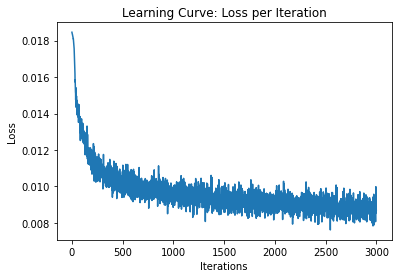

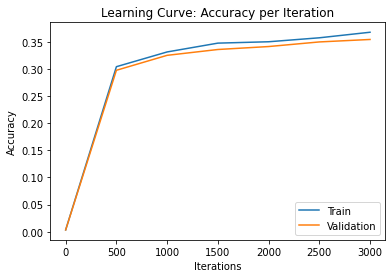

In [ ]:
pytorch_model = PyTorchWordEmb()
learning_curve_info = run_pytorch_gradient_descent(pytorch_model, checkpoint_path = '/content/gdrive/My Drive/csc413a1parameters/ckpt-{}.pk')
plot_learning_curve(*learning_curve_info)

### Part (c) -- 3 points

Write a function `make_prediction` that takes as parameters
a PyTorchWordEmb model and sentence (a list of words), and produces
a prediction for the next word in the sentence.

Start by thinking about what you need to do, step by step, taking
care of the difference between a numpy array and a PyTorch Tensor.

In [ ]:
def make_prediction_torch(model, sentence, train=False):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PyTorchWordEmb. You might find the function torch.argmax helpful.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_model, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos

    #  Write your code here

    # train the model
    if train:
      run_pytorch_gradient_descent(model)

    # input the sentence into the model

    # Convert sentence to indices
    ind_sen = [vocab_stoi[w] for w in sentence]

    # Convert sentence to one hot encoding
    one_hot_sen = make_onehot(ind_sen)

    # Convert to tensor and input into model
    out = model.forward(torch.Tensor(one_hot_sen))

    # retrieve output

    # Get index of word
    word_in = torch.argmax(out).numpy()

    # return the string 
    return vocab_itos[int(word_in)]


### Part (d) -- 4 points

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense? (If all of your predictions are the same,
train your model for more iterations, or change the hyper parameters in your
model. You may need to do this even if your training accuracy is >=37%)

One concern you might have is that our model may be "memorizing" information
from the training set.  Check if each of 3-grams (the 3 words appearing next
to each other) appear in the training set. If so, what word occurs immediately
following those three words?

In [ ]:
print(make_prediction_torch(pytorch_model, ['you', 'are', 'a']))
print(make_prediction_torch(pytorch_model, ['few', 'companies', 'show']))
print(make_prediction_torch(pytorch_model, ['there', 'are', 'no']))
print(make_prediction_torch(pytorch_model, ['yesterday', 'i', 'was']))
print(make_prediction_torch(pytorch_model, ['the', 'game', 'had']))
print(make_prediction_torch(pytorch_model, ['yesterday', 'the', 'federal']))

### Part (3) -- 1 points

Report the test accuracy of your model. The test accuracy is the percentage
of correct predictions across your test set.

In [ ]:
test_acc = estimate_accuracy_torch(pytorch_model, test4grams)
print(test_acc)

## Question 5. Visualizing Word Embeddings

While training the `PyTorchWordEmb`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings.

### Part (a) -- 1 pts

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [ ]:
word_emb_weights = list(pytorch_model.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T

word_emb[vocab_stoi["any"],:]

# Write your explanation here
# This is the case because, recall that we have chosen to represent each word as a one-hot vector
# Then, given that W^word is a vocab_size * embedding_size matrix, and we are choosing to represent
# the word has a one-hot vector, we know that by matrix multiplication rules, multiplying this vector
# by W^word will result in one of the rows of W^word being returned. 


array([ 0.19811277,  0.18181394,  0.05741554, -0.12819543, -0.3118508 ,
        0.22615135,  0.08966187, -0.06256766,  0.0780341 , -0.04211776,
       -0.20324224, -0.11297663, -0.01976839, -0.14458954, -0.05586763,
       -0.2509726 , -0.06181936,  0.08014432, -0.02984094, -0.19449079,
        0.21280663, -0.17459002, -0.18616338,  0.15353899, -0.0338647 ,
       -0.255901  , -0.02299412,  0.16948695, -0.06690563,  0.1813928 ,
        0.06673277, -0.04644088, -0.06284548,  0.1282209 ,  0.03192203,
        0.18164654, -0.13162678,  0.03357139, -0.10963649,  0.10296755,
       -0.12916076,  0.17052358, -0.04779596,  0.0551197 ,  0.04771732,
       -0.08548681,  0.31449595,  0.22674292,  0.24079081,  0.05611932,
        0.22542796, -0.15566675, -0.08035405, -0.01146581, -0.14123374,
       -0.13780627,  0.02737975, -0.17204997,  0.17493868, -0.07193454,
       -0.14012186,  0.15128611,  0.1931421 ,  0.02287123,  0.0362685 ,
        0.3238685 ,  0.0190858 ,  0.08706717, -0.17183858,  0.09

### Part (b) -- 1 pts

Once interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the cosine similarity of
every pair of words in our vocabulary.

In [ ]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.43341818
0.02629671


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [ ]:
print("four: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['four']], -6)[-6:]))
print("go: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['go']], -6)[-6:]))
print("what: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['what']], -6)[-6:]))
print("should: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['should']], -6)[-6:]))
print("school: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['school']], -6)[-6:]))
print("your: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['your']], -6)[-6:]))
print("yesterday: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['yesterday']], -6)[-6:]))
print("not: ", np.vectorize(vocab_itos.get)(np.argpartition(similarities[vocab_stoi['not']], -6)[-6:]))

four:  ['few' 'several' 'five' 'three' 'four' 'two']
go:  ['end' 'up' 'go' 'going' 'come' 'back']
what:  ['ms.' 'when' 'how' 'who' 'where' 'what']
should:  ['will' 'might' 'could' 'should' 'can' 'would']
school:  ['company' 'team' 'home' 'music' 'school' 'game']
your:  ['its' 'his' 'our' 'my' 'their' 'your']
yesterday:  ['department' ')' 'ago' 'today' 'though' 'yesterday']
not:  ['used' 'only' 'also' 'not' 'never' 'nt']


### Part (c) -- 2 pts

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment,
but we may cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.
Look at the plot and find two clusters of related words.
What do the words in each cluster have in common?

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file for your TA to see.


Answer: I see one cluster consisting of words like "several", "many", "few", which could be interpreted as words that tell you about the amount of something. I also see a cluster consisting of "my", "you", "their", which are all pronouns.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


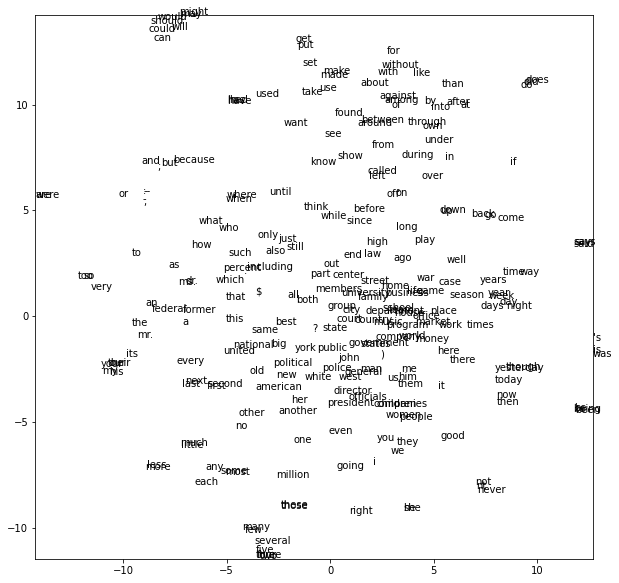

In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()